In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import nltk
nltk.download('punkt')
from nltk import FreqDist
import os
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import LdaModel
from pprint import pprint
import pandas as pd

[nltk_data] Downloading package punkt to /Users/amirraza/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**Data loading and preprocessing**

In [2]:
#directory for my saved crawled data
curr=os.getcwd()
dir=curr+'/poetry/dataset/'
print(dir)
print(os.listdir(dir))

/Users/amirraza/poetry/dataset/
['ahmad-faraz', 'meer-anees', 'naji-shakir', '.DS_Store', 'nida-fazli', 'akbar-allahabadi', 'jigar-moradabadi', 'nazm-tabatabai', 'wali-mohammad-wali', 'sahir-ludhianvi', 'naseer-turabi', 'kaifi-azmi', 'gulzar', 'fahmida-riaz', 'firaq-gorakhpuri', 'allama-iqbal', 'noon-meem-rashid', 'dagh-dehlvi', 'faiz-ahmad-faiz', 'jaun-eliya', 'altaf-hussain-hali', 'waseem-barelvi', 'mirza-ghalib', 'bahadur-shah-zafar', 'meer-taqi-meer', 'jaan-nisar-akhtar', 'habib-jalib', 'javed-akhtar', 'parveen-shakir', 'mohsin-naqvi', 'ameer-khusrau']


In [3]:
urdu_corpus=[]
cnt=0
for root, dirn, files in os.walk(dir):
    for name in files:
        base=root.split('/')[-1]
        x=os.path.join(root, name)
        if 'ur' in base:
            if cnt<3:
                print(x)
                print('==========================')
            cnt+=1
            f = open(x, "r")
            urdu_corpus.append(f.read())
            


/Users/amirraza/poetry/dataset/ahmad-faraz/ur/silsile-tod-gayaa-vo-sabhii-jaate-jaate-ahmad-faraz-ghazals
/Users/amirraza/poetry/dataset/ahmad-faraz/ur/kyaa-aise-kam-sukhan-se-koii-guftuguu-kare-ahmad-faraz-ghazals
/Users/amirraza/poetry/dataset/ahmad-faraz/ur/havaa-ke-zor-se-pindaar-e-baam-o-dar-bhii-gayaa-ahmad-faraz-ghazals


**Stop words removal**

Stopwords are words which occur with a very high frequency but usually don't have a lot of meaning. Think articles "a",'an','the' in English or prepositions.


In [4]:

stopwords_urdu=['', 'ہے', 'میں', 'سے', 'کے', 'کی', 'کو', 'تو'
                , 'نہ', 'ہیں', 'بھی', 'کا', 'نہیں'
                , 'کیا', 'دل', 'کہ', 'ہو', 'ہم'
                , 'اس', 'وہ', 'یہ', 'جو', 'نے'
                , 'و', 'تھا', 'کر', 'ہوں', 'ہی'
                , 'کوئی', 'پر', 'اور', 'کچھ', 'بے'
                , 'اب', 'ہوا', 'پہ', 'گیا', 'اک'
                , 'ہر', 'اے', 'مجھے', 'پھر', 'مجھ'
                , 'رہا', 'کس', 'جب', 'تھی', 'ایک'
                , 'جائے', 'گا', 'تم', 'جس', 'کیوں'
                , 'کبھی', 'تھے', 'مرے', 'کسی', 'گئی'
                , 'رہے', 'کہاں', 'گے', 'اپنے', 'بہت'
                , 'تک', 'آج', 'آ', 'مگر', 'ترے', 'تری'
                , 'دے', 'دیکھ', 'گئے', 'تجھ', 'اپنی'
                , 'ہوئے', 'ہوئی', 'ہوتا', 'کہیں'
                , 'دیا', 'گر', 'میرے', 'اگر','ان'
                , 'طرح','سا','گی','مری','مری'
                , 'آپ','کیے'
                , 'میری', 'آئے','بہ'
                ,'کرے','کرتے','لیا','لیے'
               ]


In [5]:
def remove_urdu_stopwords(stopwords_urdu,words):
    for stopword in stopwords_urdu:
        if stopword in words:
            words= list(filter(lambda x: x != stopword, words))
    return words

count_words_before=0
count_words_after=0
corp=[]
cnt=0
for paper in urdu_corpus:
    cnt+=1
    
    paperlines= paper.lstrip().splitlines()
    words=[sentence.split(' ') for sentence in paperlines]
    words=[j for sub in words for j in sub]
    count_words_before+= len(words)
    words= remove_urdu_stopwords(stopwords_urdu,words)
    count_words_after+=len(words)
    corp.append(words)


print('================================')
print('Sample of a tokenized document:')
print(corp[5])
print('length of this document ',len(corp[5]))
print('================================')
print('Total number of documents/ghazals ',len(corp))
print('number of token before stopwords removal ', count_words_before)
print('after removal of stopwords ', count_words_after)


Sample of a tokenized document:
['سامنے', 'ستائش', 'چاہا', 'ہونٹوں', 'جنبش', 'اہل', 'محفل', 'کب', 'احوال', 'کھلا', 'اپنا', 'خاموش', 'پرسش', 'قدر', 'تعلق', 'چلا', 'جاتا', 'رنج', 'خواہش', 'کم', 'دونوں', 'بھرم', 'قائم', 'بخشش', 'گزارش', 'ادب', 'آداب', 'پیاسا', 'رکھا', 'محفل', 'صراحی', 'گردش', 'دکھ', 'اوڑھ', 'خلوت', 'پڑے', 'رہتے', 'بازار', 'زخموں', 'نمائش', 'ابر', 'کرم', 'ویرانۂ', 'جاں', 'دشت', 'بارش', 'کٹ', 'قبیلے', 'حفاظت', 'مقتل', 'شہر', 'ٹھہرے', 'جنبش', 'ہمیں', 'بھول', 'عجب', 'فرازؔ', 'میل', 'ملاقات', 'کوشش']
length of this document  60
Total number of documents/ghazals  1314
number of token before stopwords removal  194282
after removal of stopwords  89404


Stopwords interestingly follow zipf's law, where going from the most common word (most frequent) to least common word, would follow an approximately exponential graph. 

(image source wikipedia)
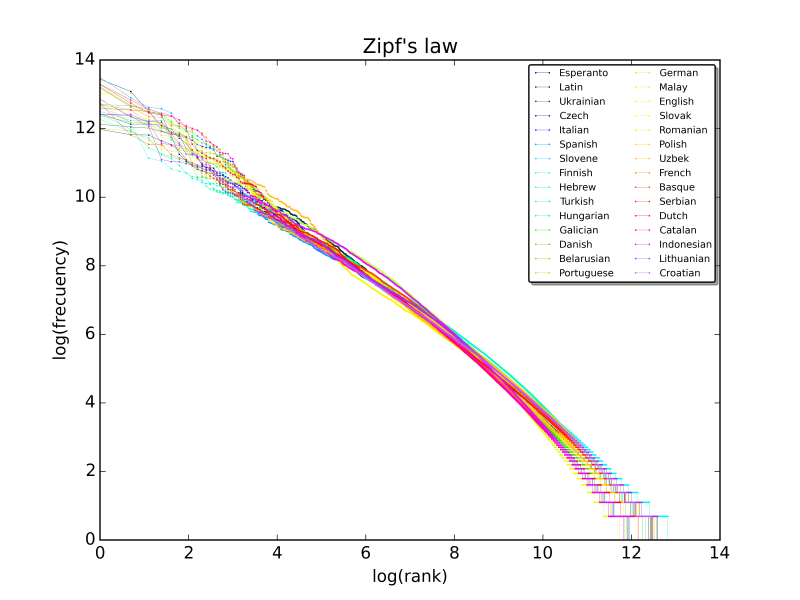

In [6]:
#checking the frequency distribution of tokens after removing stopwords
tokens= [j for sub in corp for j in sub]
fdist=FreqDist(tokens)
print('========================')
print('Token frequency distribution')
print('========================')
cnt=0
for f in fdist:
    if cnt<10:
        print(f, ' ', fdist[f])
    cnt+=1

Token frequency distribution
عشق   523
غم   467
سر   360
نظر   349
بات   311
سب   292
گل   291
یاد   269
گھر   256
رہ   248


In [7]:
if os.path.exists('./ghazal/lda_ghazals_rekhta')==False:
    id2word = corpora.Dictionary(corp)
    id2word.filter_extremes(no_below=2, no_above=0.7)
    corpus = [id2word.doc2bow(doc) for doc in corp]
    lda_model= gensim.models.ldamodel.LdaModel(corpus= corpus,  num_topics=6, random_state=100, update_every=0, passes=15  ,alpha='auto',eta='auto', per_word_topics= True)
    lda_model.save('./ghazal/lda_ghazals_rekhta')
    id2word.save_as_text("./ghazal/wordlist_ghazals_rekhta")
    np.save('./ghazal/ghazal_topic_words',topics)

else:
    lda_model=LdaModel.load('./ghazal/lda_ghazals_rekhta')
    id2word = corpora.Dictionary.load_from_text("./ghazal/wordlist_ghazals_rekhta")


In [8]:
topics = lda_model.show_topics(num_topics=-1,num_words = 3, formatted = False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in topics]

#Below Code Prints Topics and Words
for topic,words in topics_words:
    print('topic ' + str(topic)+ "::")
    for w in words :
        print(str(id2word[int(w)]))
    print('=======================')



topic 0::
ساتھ
دیکھتے
بات
topic 1::
جاتا
ملتا
ہوتے
topic 2::
ہوگا
آتے
عشق
topic 3::
خدا
غم
بات
topic 4::
غم
جاتے
یوں
topic 5::
عشق
گل
نظر


In [9]:
def make_vector_from_topic_distribution(document_topics,num_topics):
    v= np.zeros(num_topics,dtype=float)
    for dc in document_topics:
        j=dc[0]
        v[j]= dc[1]
    return v

def get_vector_document(x,lda):
    token_and_freq= id2word.doc2bow(x)
    doc_topics= lda.get_document_topics( token_and_freq, per_word_topics = False) 
    s=0
    for dc in doc_topics:
        s+=dc[1]
    v= make_vector_from_topic_distribution(doc_topics,num_topics=6)
    #print('sum of prob: ', s)
    return v
    

**Building basic topic vector representations for each of the 30 authors**

In [10]:
#Toy example
#Which two authors are most similar in terms of choice of topics or words used?

def get_tokens_for_doc(doc):
    paperlines= doc.lstrip().splitlines()
    words=[sentence.split(' ') for sentence in paperlines]
    words=[j for sub in words for j in sub]
    words= remove_urdu_stopwords(stopwords_urdu,words)
    return words

import torch

cnt=0
author_vectors=[]
authors={}
for root, dirn, files in os.walk(dir):
    for name in files:
        base=root.split('/')[-1]
        
        x=os.path.join(root, name)
        if 'ur' in base:
            author_name=root.split('/')[-2]
            if author_name not in authors:
                cnt+=1
                if cnt==3:
                    #print(authors)
                    break
                author_vector=[]
                f = open(x, "r")
                words= get_tokens_for_doc(f.read())
                vector=get_vector_document(words,lda_model)
                #print(vector)
                author_vector.append(torch.from_numpy(vector))
                f.close()
                authors[author_name]=author_vector
            else:
                f = open(x, "r")
                words=get_tokens_for_doc(f.read())
                vector=get_vector_document(words,lda_model)
                authors[author_name].append(torch.from_numpy(vector))
                f.close()
            

In [11]:
print('======================')
print('sample document vector for an author ')
print(len(authors['ahmad-faraz']))
x=authors['ahmad-faraz'][0]
print(x)
print('======================')


sample document vector for an author 
50
tensor([0.0000, 0.0000, 0.3098, 0.0000, 0.6847, 0.0000], dtype=torch.float64)


**Mean representation of all works of an author**
For now taking a mean representation for each author across his different works
this shall be the most trivial approach, to get a single representation vector for each author instead of having a list of vectors. Of course this shall be an approximate representation

In [12]:
author_mean_vectors={}
for author in authors:
    vectors=authors[author]
    x=torch.stack(vectors,dim=0).mean(dim=0)
    author_mean_vectors[author]=x


In [13]:
def get_most_similar_author(author1,author_mean_vectors):
    vector1=author_mean_vectors[author1]
    max_sim=0
    most_sim=''
    for author in author_mean_vectors:
        if author!=author1:
            sim=torch.dot(vector1,author_mean_vectors[author])
            if sim>=max_sim:
                max_sim=sim
                most_sim=author
    print(most_sim)

In [14]:
get_most_similar_author('mirza-ghalib',author_mean_vectors)            

firaq-gorakhpuri


In [15]:
get_most_similar_author('allama-iqbal',author_mean_vectors)

meer-anees


In [16]:
get_most_similar_author('javed-akhtar',author_mean_vectors)

waseem-barelvi


In [17]:
#prepare co-relation matrix
#prep data as a pandas dataframe for ease of use in correlation matrix
rows=[]
for author in author_mean_vectors:
    rows.append({'author': author,'vector':author_mean_vectors[author].numpy()})
df= pd.DataFrame(data=rows)
print(df.head(3))
print('===============')
print('===============')
df[['1','2','3','4','5','6']] = pd.DataFrame(df.vector.values.tolist(), index= df.index)
del df['vector']
print(df.head(3))


        author                                             vector
0  ahmad-faraz  [0.21965903282165528, 0.142931489944458, 0.083...
1   meer-anees  [0.02833922952413559, 0.19111739926868015, 0.1...
2   nida-fazli  [0.3649194410443306, 0.1852710150182247, 0.060...
        author         1         2         3         4         5         6
0  ahmad-faraz  0.219659  0.142931  0.083009  0.105431  0.396997  0.047185
1   meer-anees  0.028339  0.191117  0.115029  0.594038  0.037311  0.030174
2   nida-fazli  0.364919  0.185271  0.060035  0.103269  0.249652  0.030741


In [18]:
rotated_df= df.T
rotated_df.columns = rotated_df.iloc[0]
rotated_df = rotated_df[1:]
print(rotated_df.columns)

rotated_df= rotated_df.astype(float)
corrMatrix = rotated_df.corr()
print (corrMatrix)

Index(['ahmad-faraz', 'meer-anees', 'nida-fazli', 'akbar-allahabadi',
       'jigar-moradabadi', 'nazm-tabatabai', 'wali-mohammad-wali',
       'sahir-ludhianvi', 'naseer-turabi', 'kaifi-azmi', 'gulzar',
       'fahmida-riaz', 'firaq-gorakhpuri', 'allama-iqbal', 'noon-meem-rashid',
       'dagh-dehlvi', 'faiz-ahmad-faiz', 'jaun-eliya', 'altaf-hussain-hali',
       'waseem-barelvi', 'mirza-ghalib', 'bahadur-shah-zafar',
       'meer-taqi-meer', 'jaan-nisar-akhtar', 'habib-jalib', 'javed-akhtar',
       'parveen-shakir', 'mohsin-naqvi', 'ameer-khusrau'],
      dtype='object', name='author')
author              ahmad-faraz  meer-anees  nida-fazli  akbar-allahabadi  \
author                                                                      
ahmad-faraz            1.000000   -0.309093    0.719452          0.230845   
meer-anees            -0.309093    1.000000   -0.293063          0.698231   
nida-fazli             0.719452   -0.293063    1.000000          0.272630   
akbar-allahabadi   

In [19]:
import seaborn as sn
import matplotlib.pyplot as plt

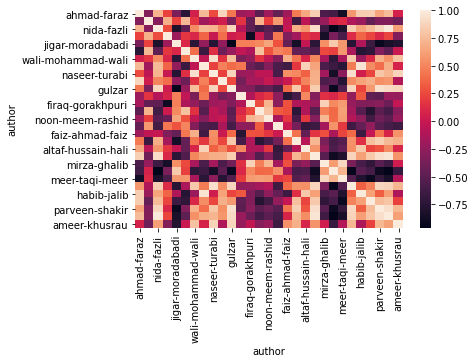

In [21]:
sn.heatmap(corrMatrix, annot=False)
plt.show()

In [74]:
def return_most_similar(record):
    x=record.sort_values(kind="quicksort",ascending=False)[:5]
    x=x[1:]
    print('Author is ----', record.name)
    print('Most similar authors are ----')
    print(x)
    print('===============================')
    
corrMatrix.apply(lambda x: return_most_similar(x) ,axis=1)



Author is ---- ahmad-faraz
Most similar authors are ----
author
kaifi-azmi        0.891351
waseem-barelvi    0.853331
habib-jalib       0.846283
javed-akhtar      0.841532
Name: ahmad-faraz, dtype: float64
Author is ---- meer-anees
Most similar authors are ----
author
nazm-tabatabai      0.746862
allama-iqbal        0.715229
akbar-allahabadi    0.698231
dagh-dehlvi         0.593203
Name: meer-anees, dtype: float64
Author is ---- nida-fazli
Most similar authors are ----
author
mohsin-naqvi      0.990560
waseem-barelvi    0.926659
gulzar            0.892752
parveen-shakir    0.892474
Name: nida-fazli, dtype: float64
Author is ---- akbar-allahabadi
Most similar authors are ----
author
meer-anees         0.698231
dagh-dehlvi        0.447979
kaifi-azmi         0.396359
sahir-ludhianvi    0.364566
Name: akbar-allahabadi, dtype: float64
Author is ---- jigar-moradabadi
Most similar authors are ----
author
bahadur-shah-zafar    0.824561
noon-meem-rashid      0.642924
meer-taqi-meer        0.579

author
ahmad-faraz           None
meer-anees            None
nida-fazli            None
akbar-allahabadi      None
jigar-moradabadi      None
nazm-tabatabai        None
wali-mohammad-wali    None
sahir-ludhianvi       None
naseer-turabi         None
kaifi-azmi            None
gulzar                None
fahmida-riaz          None
firaq-gorakhpuri      None
allama-iqbal          None
noon-meem-rashid      None
dagh-dehlvi           None
faiz-ahmad-faiz       None
jaun-eliya            None
altaf-hussain-hali    None
waseem-barelvi        None
mirza-ghalib          None
bahadur-shah-zafar    None
meer-taqi-meer        None
jaan-nisar-akhtar     None
habib-jalib           None
javed-akhtar          None
parveen-shakir        None
mohsin-naqvi          None
ameer-khusrau         None
dtype: object

A more expanded list of similar authors for some author poets:



Author is ---- kaifi-azmi

Most similar authors are ----

ahmad-faraz       0.891351

waseem-barelvi    0.698940

javed-akhtar      0.694203

habib-jalib       0.635275


Seems to make sense as Kaifi Azmi wrote songs for Bollywood movies and so did Javed Akhtar and Waseem Barelvi.

===============================

Author is ---- mirza-ghalib

Most similar authors are ----

meer-taqi-meer        0.897031

firaq-gorakhpuri      0.867845

noon-meem-rashid      0.732428

bahadur-shah-zafar    0.604054


Mirza Ghalib was a contemporary of bahadur shah zafar, hence it seems the nature of topics might have been similar. Also interestingly do these results say Ghalib was influenced a lot by the style of Meer Taqi Meer who came before him?



===============================
Author is ---- allama-iqbal

Most similar authors are ----


noon-meem-rashid    0.788498

nazm-tabatabai      0.781452

meer-anees          0.715229

meer-taqi-meer      0.623361


Allama Iqbal wrote extensively on topics related to religion and self identity.